https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [71]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV

import re
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split

from sklearn import metrics

import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
df  = pd.read_csv('data/labeled_clustered.csv',encoding='latin-1')

In [19]:
from pandas.io.json import json_normalize
import json

with open('data/scored_top.json') as json_data:
    d = json.load(json_data)
    
stories_df = json_normalize(d)
df.head()

,by,clust_label,clust_label_agg,id,text_length,title,label,type,url
0,mgdo,3,1,16989464,1539,Twitter äóñ Keeping your account secure,biz-news,story,https://blog.twitter.com/official/en_us/topics...
1,rbanffy,7,4,17012651,5119,Steve Jobs introduced the original iMac 20 yea...,biz-news,story,http://bgr.com/2018/05/06/imac-history-steve-j...
2,handpickednames,7,4,17012115,6031,Jeff Bezos is making more money out of AWS tha...,biz-news,story,http://www.afr.com/opinion/columnists/jeff-bez...
3,petethomas,7,4,17012585,4020,"L.A., are you sure you want Amazon's HQ2?",biz-news,story,http://www.latimes.com/opinion/op-ed/la-oe-gla...
4,panic,7,4,17008698,7372,"Twenty Years Ago, Steve Jobs Introduced the iM...",biz-news,story,https://512pixels.net/2018/05/20-years-imac-g3...


In [58]:
df['label'] = df.label.str.lower()

In [59]:
df['label'].value_counts()

random      1093
ml           330
github       237
news         221
dev          146
science      101
tech          79
thought       64
biz-news      56
business      50
crypto        33
Name: label, dtype: int64

In [60]:
from pandas.io.json import json_normalize
import json

with open('data/clustered_stories.json') as json_data:
    d = json.load(json_data)
    
stories_df = json_normalize(d)

In [61]:
df.head()

,by,clust_label,clust_label_agg,id,text_length,title,label,type,url
0,mgdo,3,1,16989464,1539,Twitter äóñ Keeping your account secure,biz-news,story,https://blog.twitter.com/official/en_us/topics...
1,rbanffy,7,4,17012651,5119,Steve Jobs introduced the original iMac 20 yea...,biz-news,story,http://bgr.com/2018/05/06/imac-history-steve-j...
2,handpickednames,7,4,17012115,6031,Jeff Bezos is making more money out of AWS tha...,biz-news,story,http://www.afr.com/opinion/columnists/jeff-bez...
3,petethomas,7,4,17012585,4020,"L.A., are you sure you want Amazon's HQ2?",biz-news,story,http://www.latimes.com/opinion/op-ed/la-oe-gla...
4,panic,7,4,17008698,7372,"Twenty Years Ago, Steve Jobs Introduced the iM...",biz-news,story,https://512pixels.net/2018/05/20-years-imac-g3...


In [62]:
labeled = df.dropna()
keep_cols = ['id','label']

In [63]:
labeled = labeled[keep_cols]

In [64]:
combined = labeled.merge(stories_df,on='id')

In [65]:
combined.head(2)

,id,label,by,clust_label,clust_label_agg,descendants,kids,pain_perdu,score,text,text_length,time,title,type,url
0,16989464,biz-news,mgdo,3,1,1.0,"[16989924, 16989502]",None,38,When you set a password for your Twitter accou...,1539,1525378300,Twitter – Keeping your account secure,story,https://blog.twitter.com/official/en_us/topics...
1,17012651,biz-news,rbanffy,7,4,0.0,None,None,1,"20 years ago today, Steve Jobs introduced the ...",5119,1525700941,Steve Jobs introduced the original iMac 20 yea...,story,http://bgr.com/2018/05/06/imac-history-steve-j...


In [74]:
#combined['label_id'] = combined['label'].factorize()[0]
encoder = LabelEncoder()
encoder.fit(combined['label'])
np.save('models/topic_classes.npy', encoder.classes_)

In [75]:
encoder.classes_

array(['biz-news', 'business', 'crypto', 'dev', 'github', 'ml', 'news',
       'random', 'science', 'tech', 'thought'], dtype=object)

In [76]:
# encoder = LabelEncoder()
# encoder.classes_ = np.load('models/topic_classes.npy')
# encoder.inverse_transform(combined['label_id'])

In [77]:
combined['label_id'] = encoder.transform(combined['label'])

In [78]:
X_train, X_test, y_train, y_test = train_test_split(combined.text, combined.label_id, random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [79]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(combined.text).toarray()
labels = combined.label_id


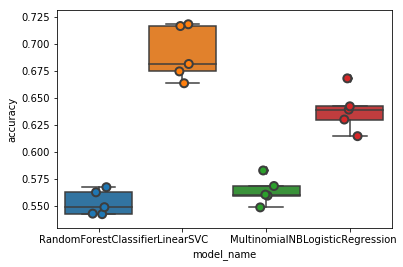

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [81]:
from sklearn.pipeline import Pipeline


tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

svm= LinearSVC()

svm_pipe = Pipeline([('tfidf', tfidf), ('svm', svm)])

In [82]:
svm_model = svm_pipe.fit(combined.text, combined.label_id)

In [83]:
from sklearn.externals import joblib
joblib.dump(svm_model, 'models/svm.pkl') 


['models/svm.pkl']

In [92]:
df = pd.DataFrame(story_list)

In [96]:
topics = np.load('models/topic_classes.npy')
topic_list = ["."+ topic for topic in topics]

In [100]:
topic_dict = {}
for topic in topics:
    topic_dict[topic]: {css_class: ".{}".format(topic),
                        count:
                       }

ValueError: dictionary update sequence element #0 has length 8; 2 is required

In [101]:
with open('data/current_top.json') as json_data:
    story_list = json.load(json_data)

In [103]:
df = pd.DataFrame(story_list)
df = df[~df.text.isnull()]
clf = joblib.load('models/svm.pkl')
df['label'] = clf.predict(df.text)
encoder = LabelEncoder()
encoder.classes_ = np.load('models/topic_classes.npy')
df['label_name'] = encoder.inverse_transform(df['label'])

/Users/gregfilla/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [116]:
df.label_name.value_counts().get('random')

43

In [115]:
for i in df.label_name.value_counts().index:
    print

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [128]:
topic_dict = {}
for topic in encoder.classes_ :
    print(topic)
    topic_dict[topic] =  {'css_class': ".{}".format(topic),
                        'display_name': topic.title(),
                        'count': df.label_name.value_counts().get(topic,0)
                       }
# #df.to_json(out_path,orient='records')

biz-news
business
crypto
dev
github
ml
news
random
science
tech
thought


In [129]:
topic_dict

{'biz-news': {'count': 1,
  'css_class': '.biz-news',
  'display_name': 'Biz-News'},
 'business': {'count': 0,
  'css_class': '.business',
  'display_name': 'Business'},
 'crypto': {'count': 0, 'css_class': '.crypto', 'display_name': 'Crypto'},
 'dev': {'count': 15, 'css_class': '.dev', 'display_name': 'Dev'},
 'github': {'count': 1, 'css_class': '.github', 'display_name': 'Github'},
 'ml': {'count': 14, 'css_class': '.ml', 'display_name': 'Ml'},
 'news': {'count': 1, 'css_class': '.news', 'display_name': 'News'},
 'random': {'count': 43, 'css_class': '.random', 'display_name': 'Random'},
 'science': {'count': 0, 'css_class': '.science', 'display_name': 'Science'},
 'tech': {'count': 3, 'css_class': '.tech', 'display_name': 'Tech'},
 'thought': {'count': 0, 'css_class': '.thought', 'display_name': 'Thought'}}

In [133]:
for i in topic_dict.keys():
    print(topic_dict[i]['css_class'])

.biz-news
.business
.crypto
.dev
.github
.ml
.news
.random
.science
.tech
.thought
